<a href="https://colab.research.google.com/github/rgozun/Credit-Default-Prediction/blob/main/UCI_Credit_Default_Prediction_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Credit Payment Default
Ralph Gozun
Data Host: UCI Machine Learning Repository
Host URL: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Abstract: This work serves to test different predictive algorithms aiming to accurately determine if a banking customer will default on their loan repayments.

Metadata: This research employed a binary variable:

* default payment (Yes = 1, No = 0), as the response variable.

This study reviewed the literature and used the following 23 variables as explanatory variables:
* X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* X2: Gender (1 = male; 2 = female).
* X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* X4: Marital status (1 = married; 2 = single; 3 = others).
* X5: Age (year).
* X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.



In [16]:
import os, warnings

from google.colab import drive 
drive.mount('/content/drive')
# Change this to your google drive directory
%cd /content/drive/My\ Drive/Colab Notebooks/UCI Credit Default/

import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

import random
from random import sample

pd.set_option('precision', 2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/UCI Credit Default


## Preprocess Data

In [17]:
# Load data from URL
df_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(df_url,header=1)
df = df.drop(columns='ID')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


Note: No interaction effects are considered between PAY_0:PAY_6 as Decision Trees do not inject bias to the predicted value.

In [21]:
# Create Categorical Vars
col_dtypes = pd.DataFrame(df.dtypes)
col_dtypes.reset_index(inplace=True)
col_dtypes.columns = ['Feature','DataType']

cat_lim = 20
for feat in col_dtypes['Feature']:
  if df[feat].nunique() < cat_lim:
    df[feat] = df[feat].astype('category')
  elif df[feat].nunique() <= 2:
    df[feat] = df[feat].astype('bol')
  else:
    pass

Note: cat_lim is arbitrary value currently chosen to determine max number of distinct values for each predictor to automatically assume it is categorical data type.

In [22]:
# Create sample proportion
pop_prop = 0.25
pop = len(df)
n = pop_prop * pop

print('sample size: n = ' + str(pop_prop) + ' * N = ' + str(n) + ', where N = ' + str(len(df)))
df_s = df.sample(frac=pop_prop, replace=False, random_state=1)

sample size: n = 0.25 * N = 7500.0, where N = 30000


## Train-Test Partition
DESCRIPTION: Train-Test split done early to keep training sample populations identical for each testing.  Doing so will remove error variations when testing, simulating, and comparing different statistical models.

## Correlation Matrix
Sample training population due to limits of RAM.

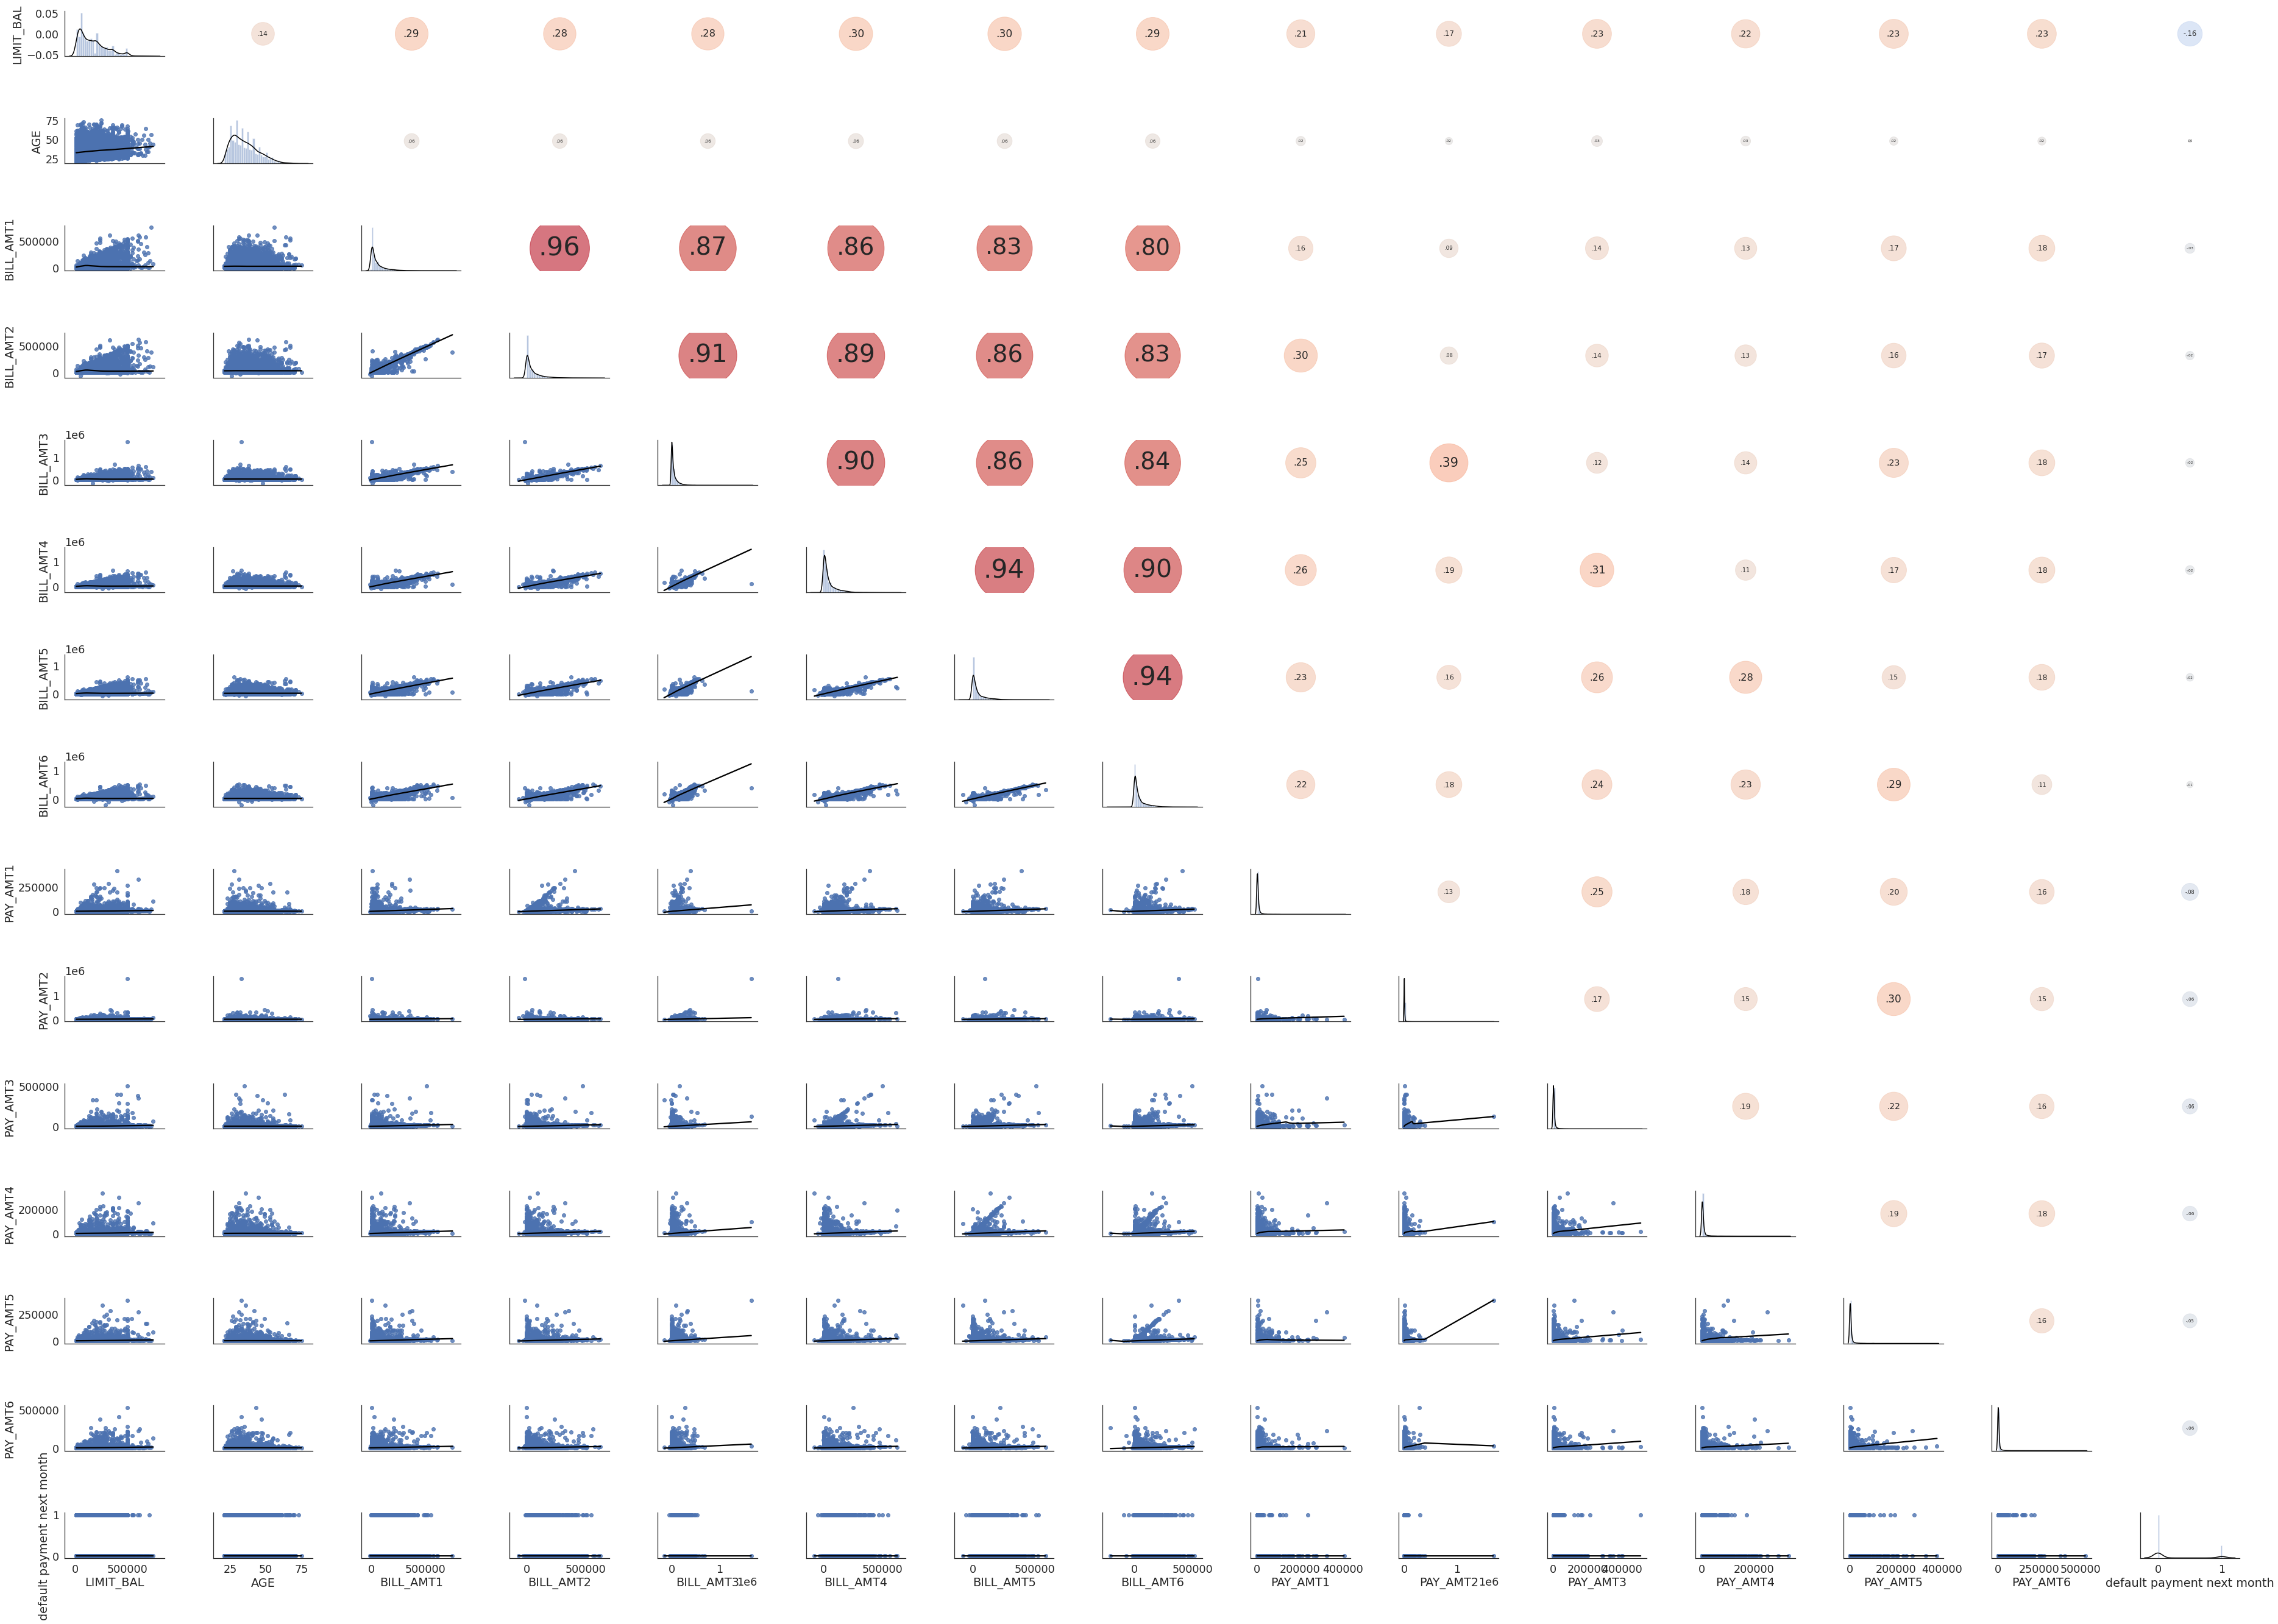

In [20]:
warnings.filterwarnings('ignore')

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(df_s, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

In [ ]:
X, y = df.iloc[:,1:23], df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.10, random_state=1)
print(X_train.head(n=2),X_test.head(n=2),y_test.head(n=2), {'Shape: ': X_train.shape})

      SEX EDUCATION MARRIAGE  AGE  ... PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6
13099   1         2        2   26  ...     1300     1300     1500     1500
4704    1         2        2   46  ...      480     3650      600        0

[2 rows x 22 columns]       SEX EDUCATION MARRIAGE  AGE  ... PAY_AMT3 PAY_AMT4 PAY_AMT5 PAY_AMT6
10747   1         3        1   32  ...     4000     3000     1000     2000
12573   2         3        1   49  ...     2828        0      182        0

[2 rows x 22 columns] 10747    0
12573    1
Name: default payment next month, dtype: category
Categories (2, int64): [0, 1] {'Shape: ': (27000, 22)}


Note: Strong right skew for each predictor.  

In [2]:
## Non-Cluster Predictive


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

## Sources

(1)  Histogram Interpretation: Skewed (Non-Normal Right); https://www.itl.nist.gov/div898/handbook/eda/section3/histogr6.htm#:~:text=For%20skewed%20distributions%2C%20it%20is,is%20on%20the%20left%20side.